In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import itertools
import seaborn
import pandas

import simulate
import harvesting
import market
import withdrawal
import numpy

In [2]:
series = market.Returns_US_1871()

In [5]:
TYPE = 'Withdrawal (Real)'
m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
     'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
     'Portfolio (Nominal)': lambda x: float(x.portfolio_n),
     'Portfolio (Real)': lambda x: float(x.portfolio_r),
}
lens = m[TYPE]
lens.__label__ = TYPE

def fn(x):
    return [lens(_) for _ in x]

def diff(x):
    (a, b) = itertools.tee(fn(x))
    for n in zip(list(a), [0.1] + list(b)):
        print(round((n[0] - n[1]) / n[1] * 1000) / 10)
        
def check_stat(x):
    (a, b) = itertools.tee(fn(x))
    diffs = [n[0] - n[1] for n in zip(list(a), [0] + list(b))]
    return(numpy.std(diffs[1:]))

In [43]:
year = 1928
VPW_YEARS=35

w = {
    'longinvest': lambda p, s: withdrawal.LonginvestSmoothing(withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'steiner' : lambda p, s: withdrawal.SteinerSmoothing(withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'rolling' : lambda p, s: withdrawal.RollingAverageSmoothing(withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'raw' : lambda p, s: withdrawal.VPW(p, s, years_left=VPW_YEARS),
    'cape10' : lambda p, s: withdrawal.CAPE10Smoothing(year, withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'rollingcape10' : lambda p, s: withdrawal.RollingAverageSmoothing(withdrawal.CAPE10Smoothing(year, withdrawal.VPW(p, s, years_left=VPW_YEARS))),
}

def run_sim(year, key, length=15):
    portfolio = (500000,500000)
    harvest_strategy = harvesting.make_rebalancer(0.5)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=w[key],
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=harvest_strategy)


pmt = run_sim(year, 'raw')
long = run_sim(year, 'longinvest')
steiner = run_sim(year, 'steiner')
rolling = run_sim(year, 'rolling')
cape10 = run_sim(year, 'cape10')
rollingcape10 = run_sim(year, 'rollingcape10')

Text(0.5, 0.98, 'Retirement in 1928')

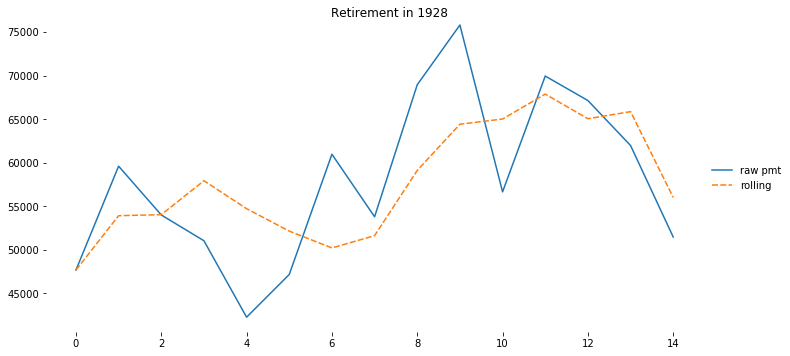

In [44]:
df = pandas.DataFrame({
    'raw pmt' : [lens(x) for x in pmt],
    'rolling' : [lens(x) for x in rolling],
})
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
#g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle(f'Retirement in {year}')

In [21]:
high = simulate.withdrawals(series.iter_from(year),
                                 withdraw=w['raw'],
                                 years=15,
                                 portfolio=(700_000, 300_000),
                                 harvesting=harvesting.make_rebalancer(0.7))
mid = simulate.withdrawals(series.iter_from(year),
                                 withdraw=w['raw'],
                                 years=15,
                                 portfolio=(500_000, 500_000),
                                 harvesting=harvesting.make_rebalancer(0.5))
low = simulate.withdrawals(series.iter_from(year),
                                 withdraw=w['raw'],
                                 years=15,
                                 portfolio=(300_000, 700_000),
                                 harvesting=harvesting.make_rebalancer(0.3))

Text(0.5, 0.98, 'Retirement in 1940')

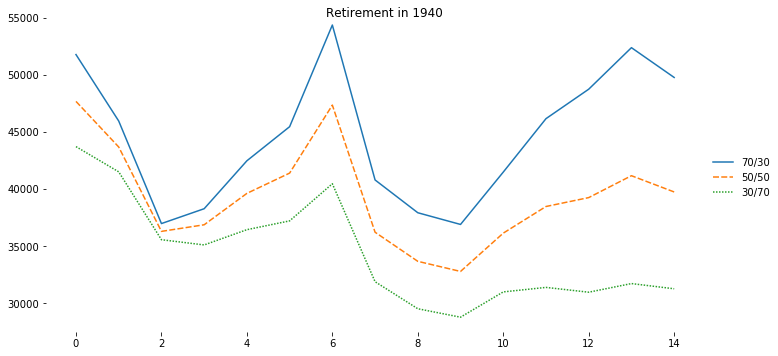

In [36]:
df = pandas.DataFrame({
    '70/30' : [lens(x) for x in high],
    '50/50' : [lens(x) for x in mid],
    '30/70' : [lens(x) for x in low],
})
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
#g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle(f'Retirement in {year}')

In [37]:
print(numpy.std([lens(x) for x in high]), 'high')
print(numpy.std([lens(x) for x in mid]), 'mid')
print(numpy.std([lens(x) for x in low]), 'low')

5697.5527445034395 high
4254.732160191506 mid
4466.33418437512 low


Text(0.5, 0.98, 'Retirement in 1940')

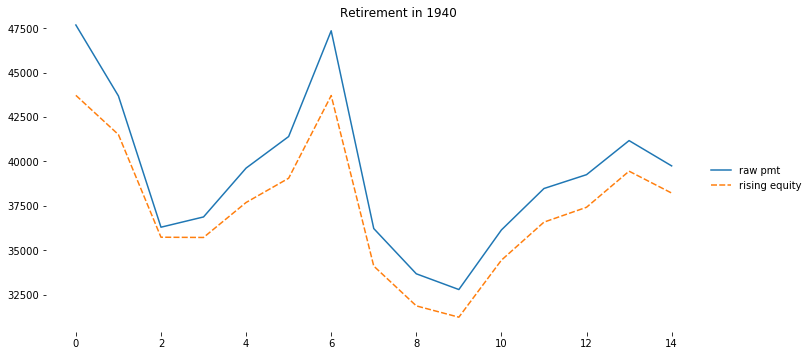

In [38]:
pmt = run_sim(year, 'raw')
glidepath = simulate.withdrawals(series.iter_from(year),
                                 withdraw=w['raw'],
                                 years=15,
                                 portfolio=(300_000, 700_000),
                                 harvesting=lambda p: harvesting.ParameterGlidepath(p, Decimal('.3'), Decimal('.8'), 30))
df = pandas.DataFrame({
    'raw pmt' : [lens(x) for x in pmt],
    'rising equity' : [lens(x) for x in glidepath],
})
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
#g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle(f'Retirement in {year}')

Text(0.5, 0.98, 'Bond % for Retirement in 1940')

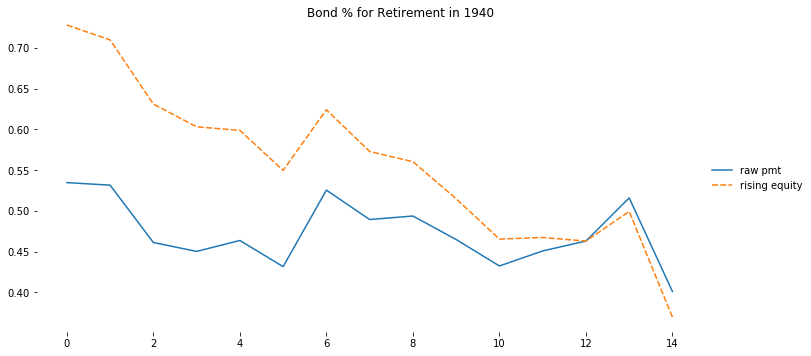

In [35]:
df = pandas.DataFrame({
    'raw pmt' : [float(x.portfolio_post.bonds / x.portfolio_post.value_n) for x in pmt],
    'rising equity' : [float(x.portfolio_post.bonds / x.portfolio_post.value_n) for x in glidepath],
})
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
#g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle(f'Bond % for Retirement in {year}')